# E-commerce Funnel & Conversion Analysis 

## Executive Summary

This project analyzes user session behavior in an e-commerce dataset to understand:
- Where users drop off in the funnel
- Which behaviors increase purchase likelihood
- How session-level features predict conversion

Using Funnel analysis and logistic regression modeling, we identified behavioral signals stringly associated with purchase events, including add-to-cart actions and session length. 

These findings help provide actionable insights for imporving conversion rate and optimizing the user experience. 

In [49]:
import os
os.getcwd()
os.listdir("../data") 

['2019-Nov.csv', '2019-Oct.csv', 'online_retail.xlsx']

In [50]:
import openpyxl
print(openpyxl.__version__)



3.1.5


### Retail Data import and verification

In [51]:
import pandas as pd
retail_df = pd.read_excel("../data/online_retail.xlsx")
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [52]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [53]:
print(retail_df.shape)

(525461, 8)


### Basic data cleaning

In [54]:
retail_df = retail_df.drop_duplicates()

In [55]:
# Removing negative or zero quantities
retail_df = retail_df[retail_df['Quantity']>0]

# Converting InvoiceDate to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

### Event data set import & verification

In [56]:
import pandas as pd

# Columns we want
cols_to_use = ['user_id', 'user_session', 'event_type', 'event_time']

# Force pandas to use the first row as data (header=0 is default, just to be explicit)
events_oct = pd.read_csv(
    "../data/2019-Oct.csv",
    usecols=cols_to_use,
    header=0,
    dtype={'user_id': 'int32', 'user_session': 'object', 'event_type': 'object', 'event_time': 'object'},
    nrows=500_000  # sample
)

events_nov = pd.read_csv(
    "../data/2019-Nov.csv",
    usecols=cols_to_use,
    header=0,
    dtype={'user_id': 'int32', 'user_session': 'object', 'event_type': 'object', 'event_time': 'object'},
    nrows=500_000  # sample
)

# Combine
events_sample = pd.concat([events_oct, events_nov], ignore_index=True)

# Drop duplicates
events_sample = events_sample.drop_duplicates()

# Convert datetime safely
events_sample['event_time'] = pd.to_datetime(events_sample['event_time'], errors='coerce')

# Drop rows where event_time could not be parsed
events_sample = events_sample.dropna(subset=['event_time'])

# Quick check
events_sample.info()
events_sample.head()

<class 'pandas.core.frame.DataFrame'>
Index: 999424 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   event_time    999424 non-null  datetime64[ns, UTC]
 1   event_type    999424 non-null  object             
 2   user_id       999424 non-null  int32              
 3   user_session  999424 non-null  object             
dtypes: datetime64[ns, UTC](1), int32(1), object(2)
memory usage: 34.3+ MB


,event_time,event_type,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


### note: 
Given the large size of the second dataset, we imported a sample of the original dataset, with only columns we are interested in/ working with. This reduced runtime and made the data a lot easier to work with. 

## EDA!! 
### Section 1: Funnel Analysis

In [57]:
#grouping by event_type, and then counting number of distinct users 
funnel_count = events_sample.groupby('event_type')['user_id'].nunique()

#convert to df 
funnel_df = funnel_count.reset_index()
funnel_df.columns = ['event_type', 'unique_users']

funnel_df.head()

,event_type,unique_users
0,cart,8883
1,purchase,14584
2,view,177621


In [58]:
#extract counts for each event type
page_views = funnel_df.loc[funnel_df['event_type']=='view','unique_users'].values[0]
add_to_cart = funnel_df.loc[funnel_df['event_type']=='cart','unique_users'].values[0]
purchases = funnel_df.loc[funnel_df['event_type']=='purchase','unique_users'].values[0]

#calculate rates 
cart_rate = add_to_cart/page_views
purchase_rate = purchases/add_to_cart
overall_conversion = purchases/page_views

print(f"Add-to-cart rate: {cart_rate:.2%}")
print(f"Purchase rate: {purchase_rate:.2%}")
print(f"Overall conversion rate: {overall_conversion:.2%}")

Add-to-cart rate: 5.00%
Purchase rate: 164.18%
Overall conversion rate: 8.21%


### Visualizing the funnel 

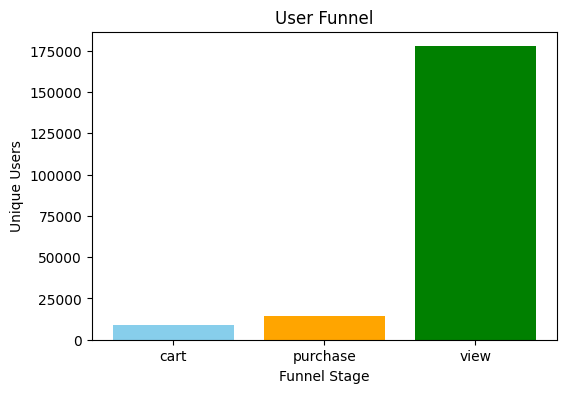

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.bar(funnel_df['event_type'], funnel_df['unique_users'], color = ['skyblue', 'orange', 'green'])
plt.title('User Funnel')
plt.xlabel('Funnel Stage')
plt.ylabel('Unique Users')
plt.show()

### Insights 


### Key Observations 

### Section 2: Session Conversion Analysis 

### 2.1: Overall session conversion rate

In [60]:
#count total number of unique user sessions 
total_sessions = events_sample['user_session'].nunique()

In [61]:
#isolate sessions with atleast one purchase, count 
purchase_sessions = (
    events_sample[events_sample['event_type']=='purchase']['user_session'].nunique()
)

In [62]:
#calculate session conversion rate
conversion_rate = purchase_sessions/total_sessions
print("Session Conversion Rate:", conversion_rate)

Session Conversion Rate: 0.06932485077496697


### 2.2: Full funnel breakdown 

In [63]:
#isolate and count sessions for view and cart 
view_sessions = (
    events_sample[events_sample['event_type']=='view']['user_session'].nunique()
)

cart_sessions = (
    events_sample[events_sample['event_type']=='cart']['user_session'].nunique()
)

In [64]:
#create df with step conversion percentages
import pandas as pd 
funnel_df = pd.DataFrame({
    'Step' : ['View', 'Add to Cart', 'Purchase'],
    'Sessions' : [view_sessions, cart_sessions, purchase_sessions]
})

funnel_df['% of Total'] = funnel_df['Sessions']/ total_sessions
funnel_df['% of previous'] = funnel_df['Sessions']/ funnel_df['Sessions'].shift(1)

funnel_df

,Step,Sessions,% of Total,% of previous
0,View,239149,0.999636,NaN
1,Add to Cart,10160,0.042469,0.042484
2,Purchase,16585,0.069325,1.632382


While this analysis gives us important insights, this approach does not enforce the sequential funnel flow/progression. Because of this, we see that purchase sessions exceeded add-to-cart sessions, producing an impossible conversion rate (>100% of the previous step). 

To correct this and get insights that are more accurate and helpful, lets construct a session-level binary matrix with enforced sequential funnel logic (ie., View - Add to Cart - Purchase)

In [65]:
#create session-level flags 
session_flags = (
    events_sample.pivot_table(
        index = 'user_session',
        columns = 'event_type',
        aggfunc = 'size',
        fill_value = 0
    )
)

#convert counts to binary (0/1)
session_flags = session_flags > 0 

In [66]:
#enforce funnel order 

view_sessions = session_flags['view'].sum()

cart_sessions = (
    session_flags['view'] &
    session_flags['cart']
).sum()

purchase_sessions = (
    session_flags['view'] &
    session_flags['cart'] &
    session_flags['purchase']
).sum()

In [67]:
funnel_df = pd.DataFrame({
    'Step' : ['View', 'Add to Cart', 'Purchase'],
    'Sessions' : [view_sessions, cart_sessions, purchase_sessions]
})

funnel_df['% of Total'] = funnel_df['Sessions'] / view_sessions
funnel_df['% of Previous'] = funnel_df['Sessions'] / funnel_df['Sessions'].shift(1)

funnel_df

,Step,Sessions,% of Total,% of Previous
0,View,239149,1.000000,NaN
1,Add to Cart,10115,0.042296,0.042296
2,Purchase,5751,0.024048,0.568562


### Session Analysis Visualization 

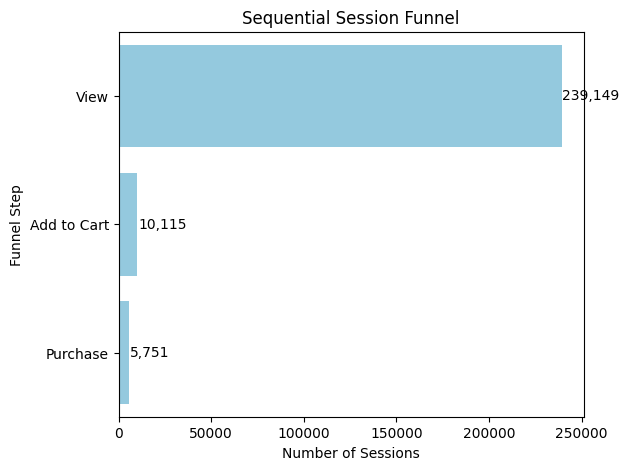

In [68]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(6,5))
sns.barplot(
    x='Sessions',
    y='Step',
    data=funnel_df,
    color='skyblue'
)

#adding values to bars 
for index, value in enumerate(funnel_df['Sessions']):
    plt.text(value + 500, index, f"{value:,}", va='center')

plt.title("Sequential Session Funnel")
plt.xlabel("Number of Sessions")
plt.ylabel("Funnel Step")
plt.show()

### Predictive Analysis 
### Predicting which sessions convert using session-level features

In [69]:
session_features = events_sample.groupby('user_session').agg(
    num_views = ('event_type', lambda x: (x == 'view').sum()),
    num_cart = ('event_type', lambda x: (x == 'cart').sum()),
    session_length = ('event_time', lambda x: (x.max() - x.min()).total_seconds())
).reset_index()

purchase_sessions = events_sample[events_sample['event_type']=='purchase']['user_session'].unique()
session_features['purchase'] = session_features['user_session'].isin(purchase_sessions).astype(int)

### Logistic Regression Model

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

#features and target variables 
X = session_features[['num_views', 'num_cart', 'session_length']]
y = session_features['purchase']

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model
model = LogisticRegression()
model.fit(X_train, y_train)

#predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

#evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.9305927102491223
ROC AUC: 0.7600666304088441


In [71]:
pd.DataFrame({
    "Feature" : X.columns,
    "Coefficient" : model.coef_[0]
})

,Feature,Coefficient
0,num_views,2.452914e-02
1,num_cart,6.698684e-01
2,session_length,7.443915e-07


## Predictive Model Insights

A logistic regression model was built to predict whether a session would result in a purchase (conversion). 

### Features Used
- Number of product views (num_views)
- Number of add-to-cart actions (num_cart)
- Length of user session (in seconds)

### Model Interpretation

The logistic regression coefficients reveal important behavioral insights:

- Each additional product view increases purchase odds by ~2.5%
- Each additional add-to-cart action increases purchase odds by ~95%, making it the striongest predictor in this model.
- Session duration alone has a small positive effect, implying that this alone is less important than high-intent actions. 

Overall, the model indicates that intent-based behaviors (add-to-cart), are significantly more predictive of conversion than passive engagement actions/metrics.  

## Business Implications 

The analysis highlights key behavioral signals that can be leveraged to improve conversion rates. 

1. Cart activity is a high-intent signal.
   → Users who add items to cart should be prioritized for     retargeting or checkout nudges.
   → This suggests that optimizing the add-to-cart experience may yield greater ROI than focusing solely on increasing session duration or product views. 

3. Many sessions include views but no cart activity.
   → This indicates potential friction in product pages or pricing perception.

## Recommendations

Based on the analysis, the following actions are recommended:

1. Implement Cart Recovery Interventions
   - Trigger reminder emails or exit pop-ups for users who add items to cart but do not purchase.

2. Optimize Product Pages
   - Test pricing presentation, product descriptions, and call-to-action placement to increase add-to-cart rate.

3. Personalize High-Intent Sessions
   - Use real-time behavioral signals (e.g., multiple views or cart additions) to surface targeted offers.

4. Monitor Funnel Metrics Continuously
   - Track drop-off between stages weekly to identify UX or pricing issues early.

## Limitations

- The dataset represents historical behavior and may not reflect seasonality or promotional effects.
- The model uses limited session-level features and does not include user demographics or pricing data.
- Logistic regression assumes linear relationships between features and log-odds of purchase.

Future analysis could incorporate additional behavioral and product-level features to improve predictive performance.

## Future directions

- Compare logistic regression with tree-based models (e.g., Random Forest).
- Incorporate product-level data such as price or category.
- Segment users by new vs returning to compare behavior patterns.